# Part I: Preprocessing of Data

In this project, we will be focusing on the datasets used in Kaggle competitions. They can be downloaded from:

https://www.kaggle.com/c/nyc-taxi-trip-duration

The purpose of the competition was to find the best model predicting the total ride duration of taxi trips in New York City. 

Let's first import the necessary modules.

In [1]:
#import time
#start_time = time.time()

In [2]:
import pandas as pd
import numpy as np

Since, we are not participating in the Kaggle competition, we will be using just the training set that contains the target variable, namely the trip duration.

In [3]:
df = pd.read_csv('NYCTripDuration.csv', parse_dates = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


We see that our dataset is quite large containing 1458644 entries. In addition to the trip duration (the target variable), the dataset includes pickup datetime, drop-off datetime, geo-coordinates of pick-up and drop-off, number of passengers, and several other variables (total of 10 feature variables). The dataset was prepared by the NYC Taxi and Limousine Commission.

In [5]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Albeit we don't expect any missing values in the Kaggle dataset, let's still ascertain that each column (out of 11) contains zero number of missing values.

In [6]:
number_of_missing_values = []
for col_name in  list(df.columns):
    number_of_missing_values.append(len(df[col_name][df[col_name].isnull() == True]))
    
# number of missing values in each of 11 columns
number_of_missing_values

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Let's now look at the 'id' and 'vendor_id' columns. The column 'vendor_id' contains just two values 1 and 2, and we will keep it. From the other side, all values in the 'id' column are different, meaning that this column can not be anyhow useful and should be dropped. 'store_and_fwd_flag' column contains two categorical variables 'Y' and 'N', so we convert them to 1 and 0.

In [7]:
df.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [8]:
print(len(df.id.value_counts().values))

df = df.drop('id', axis = 1)
#df.head()

1458644


In [9]:
#df.store_and_fwd_flag.value_counts()
df.store_and_fwd_flag = df.store_and_fwd_flag.map({'Y':1, 'N':0})

#df.head()

Let's create then the columns giving the year, month, day, hour and minute of pickup time. All data pertain to 2016 year, so we also drop this column. Also, because we have the duration of the trip in seconds, we drop then the 'dropoff_datetime' as well as 'pickup_datetime' columns. 

In [10]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

df['pickup_year'] = df.pickup_datetime.dt.year
df['pickup_month'] = df.pickup_datetime.dt.month
df['pickup_day'] = df.pickup_datetime.dt.day
df['pickup_hour'] = df.pickup_datetime.dt.hour
df['pickup_minute'] = df.pickup_datetime.dt.minute
df['pickup_day_of_week'] = df.pickup_datetime.dt.dayofweek


#df['pickup_second'] = df.pickup_datetime.dt.second

#df.head(50)

In [11]:
df.pickup_year.value_counts()

2016    1458644
Name: pickup_year, dtype: int64

In [12]:
df = df.drop(['pickup_year', 'pickup_datetime', 'dropoff_datetime'], axis = 1)

#df.head(50)

Next, we create the special column containing the geographical distance in kilometers between the pick-up and dropoff places. We use the so-called Vincenti formula for the distance that is accessible through the "geopy" module. One should notice that it takes almost 8.5 minutes to do the calculation for  1458644 observations.

Strictly speaking, we need the driving distances instead of geographical ones. Importation of the driving distances, however, requires using the geolocation-python module which uses the Google maps API. Free usage of this application is limited to only 2500 requests per day and hence impractical for large datasets. We will see that engineering the geographical distance column will be already useful.   

In [13]:
%%time

from geopy.distance import vincenty


df['geographical_dist(km)'] = df.apply(lambda row: vincenty((row['pickup_latitude'], 
                         row['pickup_longitude']), 
                        (row['dropoff_latitude'], row['dropoff_longitude'])).kilometers, axis =1)    

#df.head(20)

Wall time: 8min 2s


Finally, we convert the trip duration to being presented in hours rather than seconds. The corresponding column will be renamed to 'trip_duration(hrs)'. We also create another feature column 'effcetive_speed(kmph)', given by the ratio of the value in 'geographical_dist(km)' to that in 'trip_duration(hrs)'. This is an important column in exploratory data analysis, but we can not use it in predictive modelling because it was itself obtained using the target variable.

The new working dataframe contains now 15 features, one of which 'trip_duration(hrs)' will be our target variable. The feature columns will be the 'vendor_id', 'passenger_count', 	'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_minute', 'pickup_day_of_week', geographical_dist(km)' and 'effective_speed(kmph)' columns.

In [14]:
%%time

df['trip_duration'] = (df['trip_duration']/3600)
df = df.rename(columns = {'trip_duration':'trip_duration(hrs)'})

df['effective_speed(kmph)'] = df.apply(lambda row: row['geographical_dist(km)'] /
                                                    row['trip_duration(hrs)'], axis =1)

Wall time: 2min 51s


In [15]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration(hrs),pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_day_of_week,geographical_dist(km),effective_speed(kmph)
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,0.126389,3,14,17,24,0,1.502172,11.885316
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,0.184167,6,12,0,43,6,1.808660,9.820778
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,0.590000,1,19,11,35,1,6.379687,10.813029
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,0.119167,4,6,19,32,2,1.483632,12.450063
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,0.120833,3,26,13,30,5,1.187038,9.823760


# Part 2: Exploratory Data Analysis

Looking at our columns to start exploratory data analysis (EDA), we assume that 'vendor_id', 'passenger_count' and 'store_and_fwd_flag' columns are rather trivial and of little interest to visualize, so we focus on the data in other columns

In [28]:
import matplotlib.pyplot as plt

import seaborn as sns

1) Let's first make the boxplot of and apply the describe methods to the 'trip_duration(hrs)' column. We see that the maximum value in the dataset is as high as 979 hours, while the minimum values is around 1 second.   

In [29]:
df['trip_duration(hrs)'].describe()

count    1.458644e+06
mean     2.665256e-01
std      1.454842e+00
min      2.777778e-04
25%      1.102778e-01
50%      1.838889e-01
75%      2.986111e-01
max      9.795228e+02
Name: trip_duration(hrs), dtype: float64

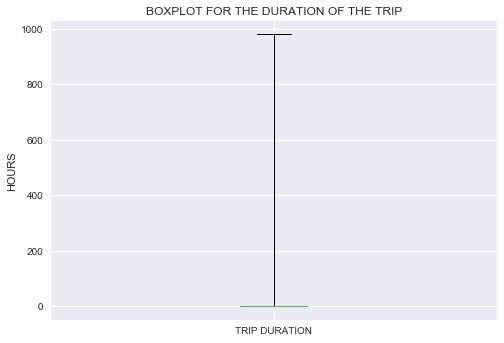

In [30]:
fig1 = plt.figure()
plt.boxplot(df['trip_duration(hrs)'], labels = ['TRIP DURATION'], whis = 'range'), 

plt.ylabel('HOURS')
plt.title('BOXPLOT FOR THE DURATION OF THE TRIP')
plt.show()

fig1.savefig('trip_dur1.pdf')

From our point of view, the durations that last more than 16 hours do not reflect a real single trip and could be either the result of data errors, or some combinations of actions or events that simply can not be interpreted as a normal trip. There are 1968 such trips.         

In [31]:
print('Number of entries for trips that last more than 16 hours:', 
      len(df['trip_duration(hrs)'][df['trip_duration(hrs)'] >16]))

Number of entries for trips that last more than 16 hours: 1968


2) Then we make the boxplot of and apply the describe methods to the 'geographical_dist(km)' column. We see that the maximum value in the dataset is as high as 1240 km, while the minimum values is just 0 km.

In [32]:
df['geographical_dist(km)'].describe()

count    1.458644e+06
mean     3.442193e+00
std      4.300259e+00
min      0.000000e+00
25%      1.232265e+00
50%      2.094045e+00
75%      3.874716e+00
max      1.240510e+03
Name: geographical_dist(km), dtype: float64

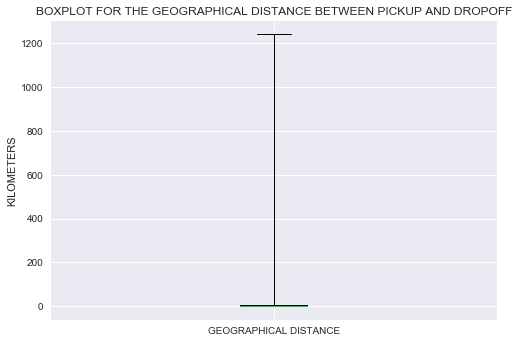

In [33]:
fig2 = plt.figure()
plt.boxplot(df['geographical_dist(km)'], labels = ['GEOGRAPHICAL DISTANCE'], whis = 'range'), 

plt.ylabel('KILOMETERS')
plt.title('BOXPLOT FOR THE GEOGRAPHICAL DISTANCE BETWEEN PICKUP AND DROPOFF')
plt.show()

fig2.savefig('geogr_dist1.pdf')

It is clear that the entries having 'geographical_dist(km)' equal to zero mean the trip did not occur at all. There are 5897 such entries. There are also 13 trips between locations separated 150 km apart. It is difficult to say whether these trips were real, but these data are anomalous from the point of view of cab drivers and passengers. 

In [34]:
print('Number of entries that did not result in a trip:', 
      len(df['geographical_dist(km)'][df['geographical_dist(km)'] == 0.0]))

Number of entries that did not result in a trip: 5897


In [35]:
print('Number of entries with the geographical distances of more than 150 km:', 
      len(df['geographical_dist(km)'][df['geographical_dist(km)'] >150]))

Number of entries with the geographical distances of more than 150 km: 13


3) The data for the 'effective_speed(kmph)' column (the artificially engineered effective speed of the travel feature) should be handled in a similar way. The minimum effective speed is 0 kmph, while the maximum is 9297 kmph.  

In [36]:
df['effective_speed(kmph)'].describe()

count    1.458644e+06
mean     1.442607e+01
std      1.498131e+01
min      0.000000e+00
25%      9.124407e+00
50%      1.279380e+01
75%      1.784544e+01
max      9.279582e+03
Name: effective_speed(kmph), dtype: float64

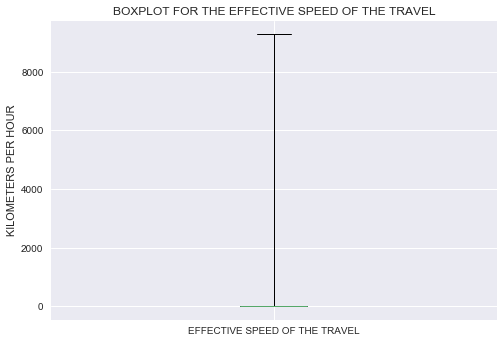

In [37]:
fig3 = plt.figure()
plt.boxplot(df['effective_speed(kmph)'], labels = ['EFFECTIVE SPEED OF THE TRAVEL'], 
            whis = 'range') 

plt.ylabel('KILOMETERS PER HOUR')
plt.title('BOXPLOT FOR THE EFFECTIVE SPEED OF THE TRAVEL')
plt.show()

fig3.savefig('effective_speed1.pdf')

The speed limit in New York is 55mph, or 88.5 kmph. There are 205 trips that resulted in effective speed greater than the speed limit.

In [38]:
print('The trips that rsulted in effective speed greater than 88.5 kmph:', 
      len(df['effective_speed(kmph)'][df['effective_speed(kmph)'] > 88.5]))

The trips that rsulted in effective speed greater than 88.5 kmph: 205


4) We remove from the data: (i) trips that lasted more than 16 hours, (ii) trips with the geographical distances of either 0 km or more than 150 km, (iii) trips where the effective speed was greater than the speed limit. 

In [39]:
df = df[df['trip_duration(hrs)'] < 16]

df = df[(df['geographical_dist(km)'] < 150) & (df['geographical_dist(km)'] != 0.0)]

df = df[df['effective_speed(kmph)'] < 88.5]


In [40]:
df.reset_index(drop = True, inplace = True)

5) We also remove two entries with suspicious longitudes from the dataframe (entries 1177854, and  1062842), since it is unlikely that those trips occurred in New York, and these points may negatively affect predictive data analysis. Our column will then contain 1450573 instances.

In [41]:
#df['dropoff_latitude'].sort_values()
#df['pickup_latitude'].sort_values()

#df['pickup_longitude'].sort_values()
df['dropoff_longitude'].sort_values()

1177854   -121.933304
1062842   -121.933205
245594     -74.775429
382960     -74.728508
503458     -74.725815
291635     -74.711327
1146569    -74.705360
611791     -74.663643
235329     -74.647537
334524     -74.613152
596529     -74.613113
659388     -74.612503
190770     -74.602432
1201744    -74.584427
1247253    -74.580826
611038     -74.580559
831428     -74.571686
949589     -74.569748
698077     -74.566757
81392      -74.562355
1097117    -74.550011
1095363    -74.542084
71832      -74.533859
1401660    -74.524940
321477     -74.521576
518279     -74.511681
150669     -74.479622
384424     -74.474556
1332298    -74.473152
1064342    -74.459000
              ...    
689009     -73.341927
850325     -73.332817
1242291    -73.332809
983905     -73.324074
1240676    -73.311806
813281     -73.290527
1446676    -73.287422
705168     -73.287102
136187     -73.258476
492839     -73.252541
767460     -73.248070
894421     -73.225014
226532     -73.205513
1387447    -73.195259
85298     

In [42]:
df.drop([1177854, 1062842], inplace=True)
df.reset_index(drop = True, inplace = True)

#df['pickup_longitude'].sort_values()
len(df.index)

1450573

6) The mean value of the trip duration is 0.23 hour, while the standard deviation is 0.2 hour. The mean value of the geographical distance between pickup and dropoff is only 3.45 km with the standard deviation being 3.95 km. We see that the trip durations and geographical distances are quite broadly distributed. We see also that the average effective speed for the taxi trips in New York is rather small (14.4 km per hour which is smaller than 20 km per hour); this is quite reasonable for a busy megapolis. Larger speeds are likely to occur for the intercity trips in which the high-speed highways were used. 

In [43]:
print('The mean value of the trip duration is', df['trip_duration(hrs)'].mean(), 'hours')
print('The standard dev. of the trip duration is', df['trip_duration(hrs)'].std(), 'hours')

print('\n')
print('The mean value of the geographical distance between pickup and dropoff is', 
      df['geographical_dist(km)'].mean(), 'km')
print('The standard dev. of the geographical distance between pickup and dropoff is', 
      df['geographical_dist(km)'].std(), 'km')

print('\n')
print('The mean value of the effective speed of the trips is', 
      df['effective_speed(kmph)'].mean(), 'kmph')
print('The standard dev. of the effective speed of the trips is', 
      df['effective_speed(kmph)'].std(), 'kmph')

The mean value of the trip duration is 0.23361777897424194 hours
The standard dev. of the trip duration is 0.201671452699607 hours


The mean value of the geographical distance between pickup and dropoff is 3.450736982368836 km
The standard dev. of the geographical distance between pickup and dropoff is 3.952023489561631 km


The mean value of the effective speed of the trips is 14.448243417805493 kmph
The standard dev. of the effective speed of the trips is 7.710025255686694 kmph


7) We then make the boxplots of the the 'trip_duration(hrs)', 'geographical_dist(km)', 'effective_speed(kmph)' once, what we believe the anomalous data has been removed. The plots reveal that there is still a small number of trips that lasted either very long, or resulted in large travel distances. This means that the data for the trip duration as well as for geographical distances have very long tails in their distributions.

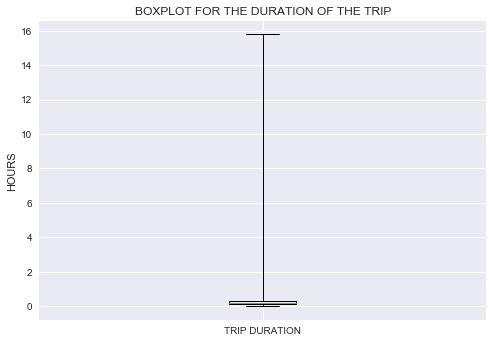

In [44]:
fig4 = plt.figure()
plt.boxplot(df['trip_duration(hrs)'], labels = ['TRIP DURATION'], whis = 'range'), 

plt.ylabel('HOURS')
plt.title('BOXPLOT FOR THE DURATION OF THE TRIP')
plt.show()

fig4.savefig('trip_dur2.pdf')

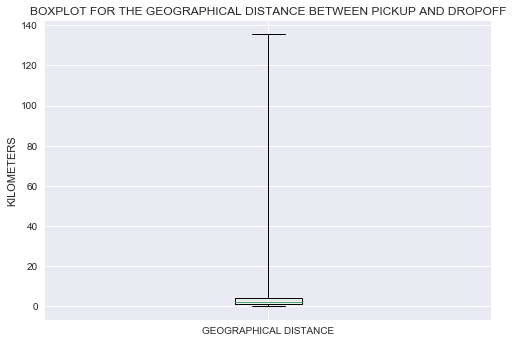

In [45]:
fig5 = plt.figure()
plt.boxplot(df['geographical_dist(km)'], labels = ['GEOGRAPHICAL DISTANCE'], whis = 'range'), 

plt.ylabel('KILOMETERS')
plt.title('BOXPLOT FOR THE GEOGRAPHICAL DISTANCE BETWEEN PICKUP AND DROPOFF')
plt.show()

fig5.savefig('geogr_dist2.pdf')

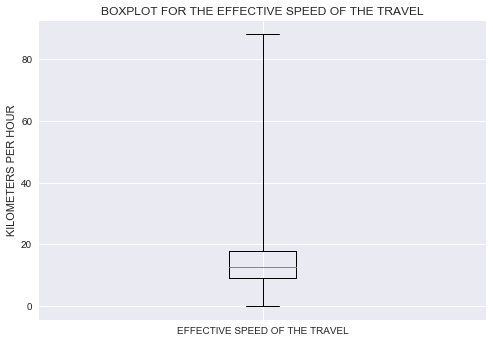

In [47]:
fig6 = plt.figure()
plt.boxplot(df['effective_speed(kmph)'], labels = ['EFFECTIVE SPEED OF THE TRAVEL'], 
            whis = 'range') 

plt.ylabel('KILOMETERS PER HOUR')
plt.title('BOXPLOT FOR THE EFFECTIVE SPEED OF THE TRAVEL')
plt.show()

fig6.savefig('effective_speed2.pdf')

8) Let's make four bar plots for the trip numbers for given values in the 'pickup_month', 'pickup_day', 'pickup_hour' and 'pickup_day_of_week' columns. The first bar plot suggests that the number of trips does not vary significantly with month, while the plot displaying the number of trips per given day of each month suggests that people are slightly more reluctant to take cabs during the third decade of each month. The number of trips made on the 31st day is roughly half the similar number for any other day, which is expected. The third plot, that shows the hourly distribution of the number of trips, reveals that 6,7,8,9 and 10 pm are the busiest hours, while late night and early morning are the least busiest ones. Finally, the last plot suggests that people are least likely to take cabs on Sundays, Mondays and Tuesdays.

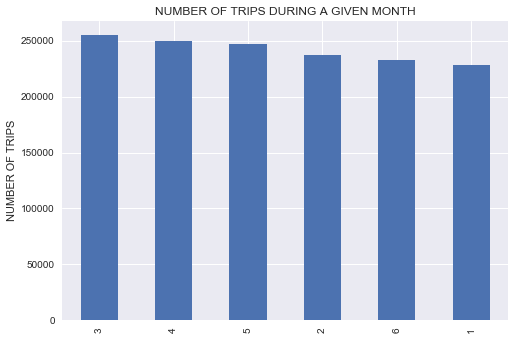

In [48]:
fig7 = df['pickup_month'].value_counts().\
      plot(title = 'NUMBER OF TRIPS DURING A GIVEN MONTH',kind = 'bar').get_figure()
plt.ylabel('NUMBER OF TRIPS')
plt.show()

fig7.savefig('trips_per_month.pdf')

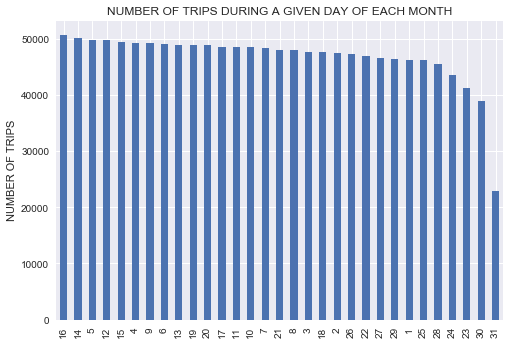

In [49]:
fig8 = df['pickup_day'].value_counts().\
      plot(title = 'NUMBER OF TRIPS DURING A GIVEN DAY OF EACH MONTH',kind = 'bar').get_figure()
plt.ylabel('NUMBER OF TRIPS')
plt.show()

fig8.savefig('trips_per_day_of_month.pdf')

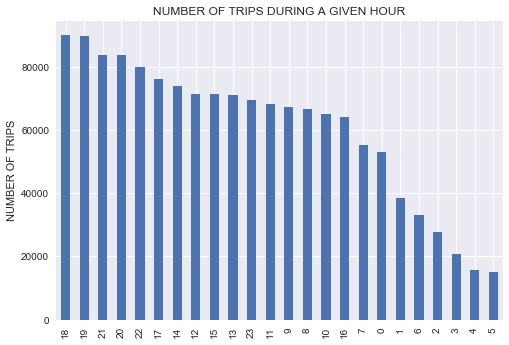

In [50]:
fig9 = df['pickup_hour'].value_counts().\
      plot(title = 'NUMBER OF TRIPS DURING A GIVEN HOUR',kind = 'bar').get_figure()
plt.ylabel('NUMBER OF TRIPS')
plt.show()

fig9.savefig('trips_per_hour.pdf')

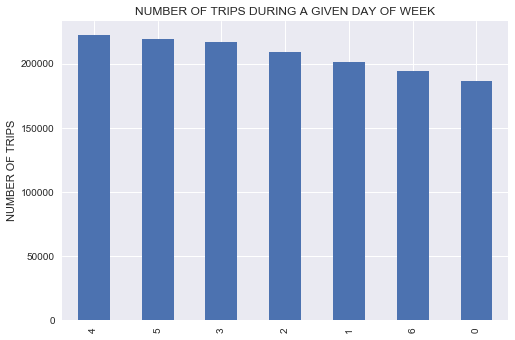

In [51]:
fig10 = df['pickup_day_of_week'].value_counts().\
      plot(title = 'NUMBER OF TRIPS DURING A GIVEN DAY OF WEEK',kind = 'bar').get_figure()
plt.ylabel('NUMBER OF TRIPS')
plt.show()

fig10.savefig('trips_per_day_of_week.pdf')

9) Let's now plot the heat map of the correlation matrix array choosing the following columns: 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_hour', 'pickup_day_of_week', 'geographical_dist(km)', 'effective_speed(kmph)' and the target column 'trip_duration(hrs)'. Values in the 'pickup_month'and 'pickup_day' columns, having almost uniform distributions, are almost not correlated with anything else, and we are not plotting these columns.  We see that the dropoff and pickup longitudes are rather strongly correlated with each other; the same can be said about the dropoff and pickup latitudes. There is also a notable correlation between the values in the 'geographical_dist(km)' and 'effective_speed(kmph)' columns, which is not unexpected. There is also weak but far from zero correlation between the values in 'geographical_dist(km)' column and those in the 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude' columns respectively; this latter fact can be explained by the presence of the sea coast near New York city. There is a strong correlation between the 'trip_duration(hrs)' values and the values in the 'geographical_dist(km)' column. The 'trip_duration(hrs)' values are only a little bit correlated with the values in the 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude' columns.

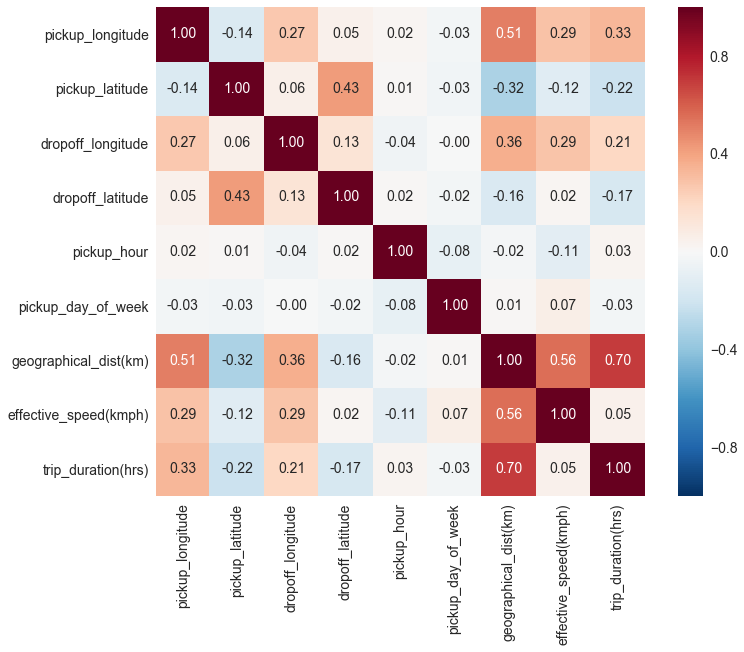

In [52]:
sns.set(font_scale=1.4)

plt.subplots(figsize=(12,9))
#sel_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
#'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_day_of_week', 'geographical_dist(km)', 
#'effective_speed(kmph)', 'trip_duration(hrs)']


sel_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
          'pickup_hour', 'pickup_day_of_week', 'geographical_dist(km)', 'effective_speed(kmph)', 
          'trip_duration(hrs)']

cm = np.corrcoef(df[sel_cols].values.T)

hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', 
                 annot_kws = {'size': 14}, 
                 yticklabels = sel_cols, xticklabels = sel_cols)
plt.show()

fig8 = hm.get_figure()
fig8.savefig('cor_heatmap.pdf')

sns.reset_orig()

10) Finally, we make the seaborn pair plot involving the columns 'geographical_dist(km)',  'effective_speed(kmph)', and 'trip_duration(hrs)'. It follows from the plot that geographical distances between the pickup and dropoff locations are narrowly distributed with a small number of large distances. The same is true for the trip durations -- there are few instances with very large time intervals. Large trip durations probably mean substantial waiting periods during the trips as follows from the scatter plots 'trip_duration(hrs)' vs  'geographical_dist(km)' and 'effective_speed(kmph)'. One should pay attention to the broad distributions of effective speeds. It follows from the data that low effective speeds correspond to the presence of notable waiting periods during which there was no motion of the cab, but taximeter kept counting. One can also conclude that the larger geographical distance the higher the effective speed is. Also, the larger trip durations correspond, on average, to smaller effective speeds, as expected.

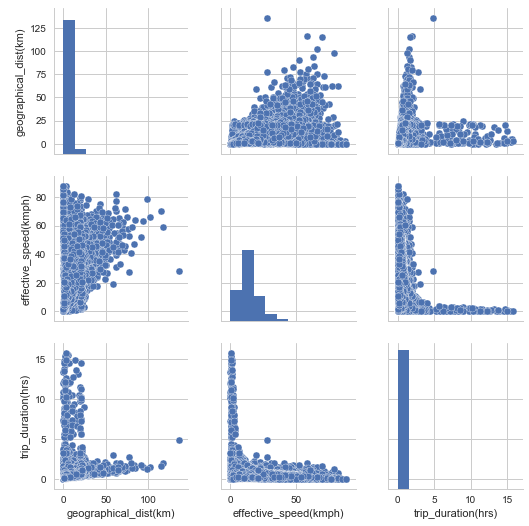

Wall time: 6min 40s


In [53]:
%%time

sns.set(font_scale = 1.5)
sns.set(style = 'whitegrid', context = 'notebook')

sel_cols2 = ['geographical_dist(km)', 'effective_speed(kmph)', 'trip_duration(hrs)']

scm1 = sns.pairplot(df[sel_cols2], size = 2.5)
plt.show()

scm1.savefig('scat_matr1.png')

sns.reset_orig()

We have now the modified dataframe that is ready for predictive modelling using certain methods. We convert it back to the csv file ('NYCTripDuration_modified.csv') to use it in another program.     

In [54]:
df.to_csv('NYCTripDuration_modified.csv')

In [42]:
#print("--- Time to execute the program is {} minutes ---".format((time.time() - start_time)/60))

# Part IV: Conclusions and Recommendations

3a) Let's try to answer the equestion: Where do the fastest trips originate? To do this we use the Basemap module from mpl_toolkits.basemap. We plot the map of New-York and, on top of it, the pickup latitudes and longitudes of the arbitrary chosen 3000 trips whose effective speed is as least twice the average effective speed. It is very interesting that the fastest trips originate mainly in Manhattan, but their final destinations have much broader geography.

In [43]:
import matplotlib.cm
from mpl_toolkits.basemap import Basemap

import geopandas as gpd

In [44]:
#len(df[df['effective_speed(kmph)'] > 2.0*df['effective_speed(kmph)'].mean()])

df_aux = df[df['effective_speed(kmph)'] > 2.0*df['effective_speed(kmph)'].mean()]

df_aux = df_aux.sample(frac =1)
df_aux.reset_index(drop = True, inplace = True)

df_aux = df_aux.iloc[:3000]


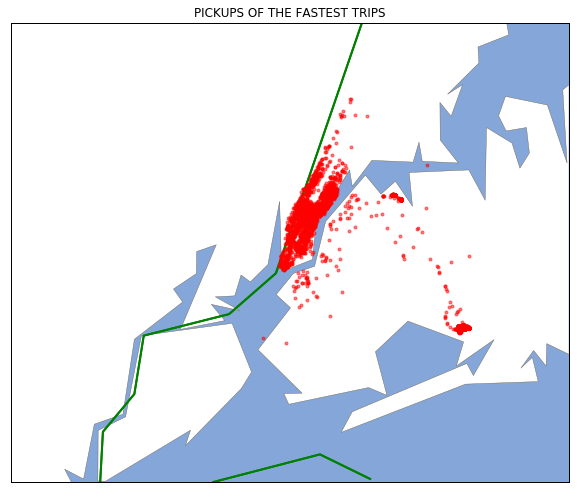

In [45]:
fig, ax = plt.subplots(figsize=(10,10))

m = Basemap(resolution = 'i',
            projection='merc',
            #lat_0=54.5, lon_0=-4.36,
            llcrnrlon=-74.359561, llcrnrlat= 40.496326, urcrnrlon=-73.64957, urcrnrlat=40.939728)


m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
m.drawstates(color='g', linewidth=2)

for i in range(len(df_aux.index)):
    lat, lon = df_aux['pickup_latitude'][i], df_aux['pickup_longitude'][i]
    x, y = m(lon, lat)
    m.plot(x,y, 'r.', alpha = 0.5)
    

#shp1= gpd.GeoDataFrame.from_file('nybb_18a/nybb.shp')
#shp1.crs = {'init': 'epsg:4326'}

#shapefile_path = 'nybb_18a/nybb1'
#m.readshapefile(shapefile_path, 'boroughs')

plt.title('PICKUPS OF THE FASTEST TRIPS')
plt.show()

fig.savefig('fast_pickups.pdf')

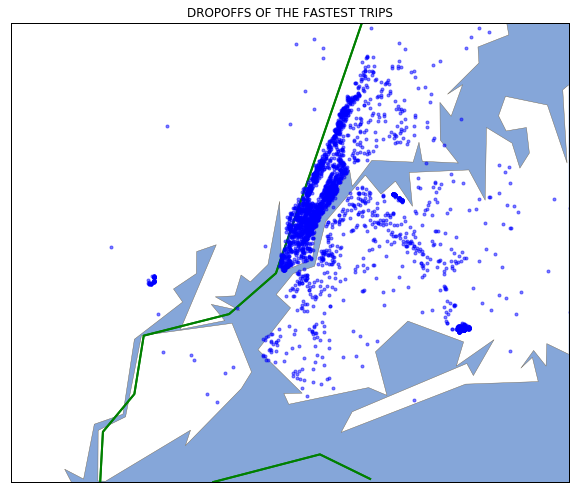

In [46]:
fig, ax = plt.subplots(figsize=(10,10))

m = Basemap(resolution = 'i',
            projection='merc',
            #lat_0=54.5, lon_0=-4.36,
            llcrnrlon=-74.359561, llcrnrlat= 40.496326, urcrnrlon=-73.64957, urcrnrlat=40.939728)


m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
m.drawstates(color='g', linewidth=2)

for i in range(len(df_aux.index)):
    lat, lon = df_aux['dropoff_latitude'][i], df_aux['dropoff_longitude'][i]
    x, y = m(lon, lat)
    m.plot(x,y, 'b.', alpha = 0.5)
    

#shp1= gpd.GeoDataFrame.from_file('nybb_18a/nybb.shp')
#shp1.crs = {'init': 'epsg:4326'}

#shapefile_path = 'nybb_18a/nybb1'
#m.readshapefile(shapefile_path, 'boroughs')

plt.title('DROPOFFS OF THE FASTEST TRIPS')
plt.show()

fig.savefig('fast_dropoffs.pdf')

3b) The same investigation can be done for the slowest trips, namely those whose effective speed is smaller than half of the average effective speed. We also limit ourselves to plotting only 3000 random samples. The results show that though dropoff geographical distribution is a bit broader than pickup one, the overwhelming majority of the slowest trips start or end in Manhattan. 

One can conclude that the majority of people who take cabs travel from/to Manhattan, and that the effective speed of the trip is determined by how busy the traffic in Manhattan is. In such a case, one can recommend the estimation of the time of the trip by simply looking at the traffic congestion near Manhattan.   

In [56]:
#len(df[df['effective_speed(kmph)'] < 0.5*df['effective_speed(kmph)'].mean()])

df_aux = df[df['effective_speed(kmph)'] < 1.5*df['effective_speed(kmph)'].mean()]

df_aux = df_aux.sample(frac =1)
df_aux.reset_index(drop = True, inplace = True)

df_aux = df_aux.iloc[:3000]

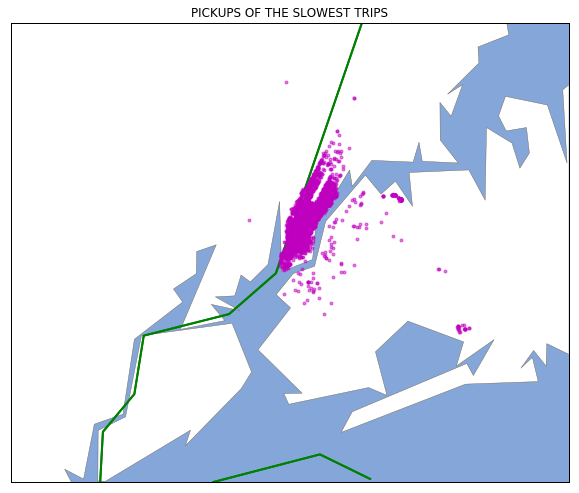

In [57]:
fig, ax = plt.subplots(figsize=(10,10))

m = Basemap(resolution = 'i',
            projection='merc',
            #lat_0=54.5, lon_0=-4.36,
            llcrnrlon=-74.359561, llcrnrlat= 40.496326, urcrnrlon=-73.64957, urcrnrlat=40.939728)


m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
m.drawstates(color='g', linewidth=2)

for i in range(len(df_aux.index)):
    lat, lon = df_aux['pickup_latitude'][i], df_aux['pickup_longitude'][i]
    x, y = m(lon, lat)
    m.plot(x,y, 'm.', alpha = 0.5)
    

#shp1= gpd.GeoDataFrame.from_file('nybb_18a/nybb.shp')
#shp1.crs = {'init': 'epsg:4326'}

#shapefile_path = 'nybb_18a/nybb1'
#m.readshapefile(shapefile_path, 'boroughs')

plt.title('PICKUPS OF THE SLOWEST TRIPS')
plt.show()

fig.savefig('slow_pickups.pdf')

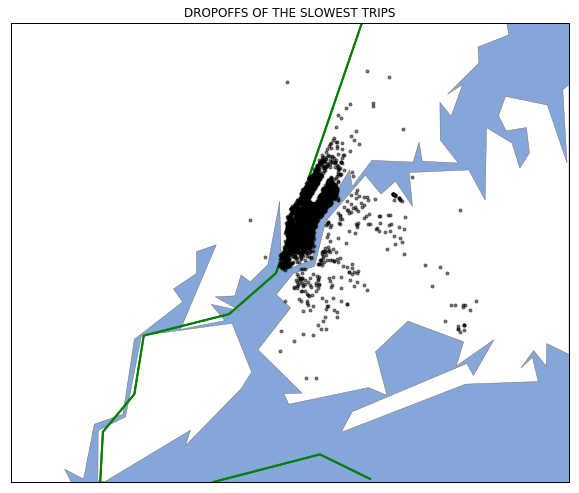

In [58]:
fig, ax = plt.subplots(figsize=(10,10))

m = Basemap(resolution = 'i',
            projection='merc',
            #lat_0=54.5, lon_0=-4.36,
            llcrnrlon=-74.359561, llcrnrlat= 40.496326, urcrnrlon=-73.64957, urcrnrlat=40.939728)


m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
m.drawstates(color='g', linewidth=2)

for i in range(len(df_aux.index)):
    lat, lon = df_aux['dropoff_latitude'][i], df_aux['dropoff_longitude'][i]
    x, y = m(lon, lat)
    m.plot(x,y, 'k.', alpha = 0.5)
    

#shp1= gpd.GeoDataFrame.from_file('nybb_18a/nybb.shp')
#shp1.crs = {'init': 'epsg:4326'}

#shapefile_path = 'nybb_18a/nybb1'
#m.readshapefile(shapefile_path, 'boroughs')

plt.title('DROPOFFS OF THE SLOWEST TRIPS')
plt.show()

fig.savefig('slow_dropoffs.pdf')

In [55]:
len(df[df['effective_speed(kmph)'] < 0.5*df['effective_speed(kmph)'].mean()])

190285